In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics

In [2]:
data = pd.read_csv('Datas/DataTreinamentoDevAcademy/data_1__.csv', date_parser = 'data')
data_test = pd.read_csv('Datas/DataTreinamentoDevAcademy/data_1__test.csv', date_parser = 'data')
data.head(20)

,index,data,valor
0,0,2016-08-29,9.00
1,1,2016-08-30,1.60
2,2,2016-08-31,15311.70
3,3,2016-09-01,13932.67
4,4,2016-09-02,11535.45
5,5,2016-09-03,25864.32
6,6,2016-09-04,161344.35
7,7,2016-09-07,46380.31
8,8,2016-09-08,7341.94
9,9,2016-09-09,20184.57


In [3]:
data_test.head()

,index,data,valor
0,568,2018-10-03,15895.50
1,569,2018-10-04,9273.00
2,570,2018-10-05,16079.25
3,571,2018-10-06,29740.60
4,572,2018-10-07,45392.70


In [4]:
data['data'] = data['data'].astype('datetime64[ns]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   568 non-null    int64         
 1   data    568 non-null    datetime64[ns]
 2   valor   568 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.4 KB


In [5]:
data.tail()

,index,data,valor
563,563,2018-09-26,13598.15
564,564,2018-09-27,9937.20
565,565,2018-09-28,21288.81
566,566,2018-09-29,20712.30
567,567,2018-09-30,85709.60


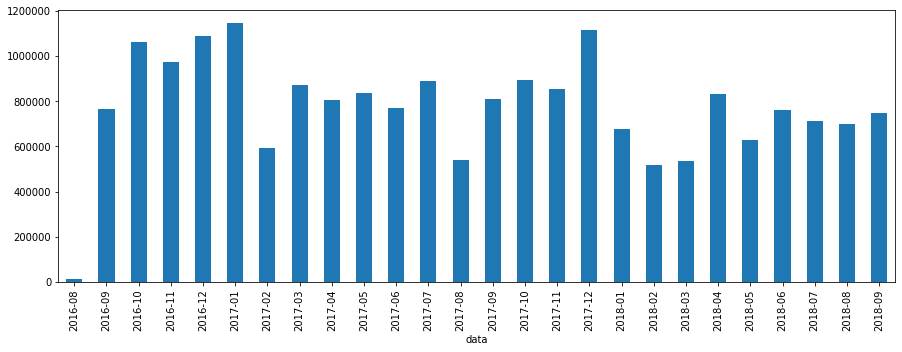

In [6]:
data['valor'].groupby(data['data'].dt.to_period('M')).sum().plot(kind='bar', figsize=(15,5))

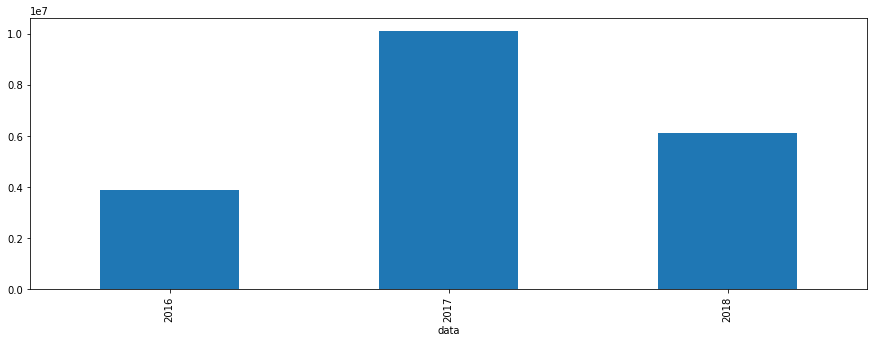

In [7]:
data['valor'].groupby(data['data'].dt.to_period('Y')).sum().plot(kind='bar', figsize=(15,5))

In [8]:
data_train = data[['valor']].values
#data_train = data.iloc[:, 2:3].values

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler.fit_transform(np.array(data_train))

In [10]:
previsores = []
preco_real = []
for i in range(5, len(data)):
    previsores.append(data_train_scaled[i-5:i, 0])
    preco_real.append(data_train_scaled[i, 0])

In [11]:
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [12]:
dt_values = pd.DataFrame(previsores)
dt_values[5] = pd.DataFrame(preco_real)
dt_values.head()

,0,1,2,3,4,5
0,0.000046,0.000008,0.077984,0.070960,0.058751,0.131729
1,0.000008,0.077984,0.070960,0.058751,0.131729,0.821743
2,0.077984,0.070960,0.058751,0.131729,0.821743,0.236219
3,0.070960,0.058751,0.131729,0.821743,0.236219,0.037393
4,0.058751,0.131729,0.821743,0.236219,0.037393,0.102802


In [13]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(563, 5, 1)

### using RNN with keras for predict Time Series

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [15]:
regressor = Sequential()
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 5, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 5, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 5))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

In [16]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

In [17]:
#es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
#rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
#mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
#                      save_best_only = True, verbose = 1)


In [18]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 16)
              #callbacks = [es, rlr, mcp])

Epoch 1/100
563/563 [==============================] - 2s 4ms/step - loss: 0.1056 - mean_absolute_error: 0.2999
Epoch 2/100
563/563 [==============================] - 0s 514us/step - loss: 0.0616 - mean_absolute_error: 0.2228
Epoch 3/100
563/563 [==============================] - 0s 505us/step - loss: 0.0432 - mean_absolute_error: 0.1730
Epoch 4/100
563/563 [==============================] - 0s 474us/step - loss: 0.0385 - mean_absolute_error: 0.1484
Epoch 5/100
563/563 [==============================] - 0s 490us/step - loss: 0.0406 - mean_absolute_error: 0.1492
Epoch 6/100
563/563 [==============================] - 0s 505us/step - loss: 0.0404 - mean_absolute_error: 0.1545
Epoch 7/100
563/563 [==============================] - 0s 505us/step - loss: 0.0408 - mean_absolute_error: 0.1503
Epoch 8/100
563/563 [==============================] - 0s 505us/step - loss: 0.0407 - mean_absolute_error: 0.1577
Epoch 9/100
563/563 [==============================] - 0s 497us/step - loss: 0.0389 - mean

563/563 [==============================] - 0s 535us/step - loss: 0.0311 - mean_absolute_error: 0.1289
Epoch 73/100
563/563 [==============================] - 0s 528us/step - loss: 0.0308 - mean_absolute_error: 0.1273
Epoch 74/100
563/563 [==============================] - 0s 532us/step - loss: 0.0305 - mean_absolute_error: 0.1271
Epoch 75/100
563/563 [==============================] - 0s 528us/step - loss: 0.0301 - mean_absolute_error: 0.1281
Epoch 76/100
563/563 [==============================] - 0s 519us/step - loss: 0.0318 - mean_absolute_error: 0.1282
Epoch 77/100
563/563 [==============================] - 0s 496us/step - loss: 0.0311 - mean_absolute_error: 0.1278
Epoch 78/100
563/563 [==============================] - 0s 537us/step - loss: 0.0310 - mean_absolute_error: 0.1274
Epoch 79/100
563/563 [==============================] - 0s 536us/step - loss: 0.0304 - mean_absolute_error: 0.1251
Epoch 80/100
563/563 [==============================] - 0s 532us/step - loss: 0.0311 - mean_a

In [19]:
data_total = pd.concat((data['valor'], data_test['valor']), axis = 0)
entradas = data_total[len(data_total) - len(data_test) - 5:].values
entradas = entradas.reshape(-1, 1)
entradas = scaler.transform(entradas)
preco_real_test = data_test[['valor']].values

In [20]:
X_teste = []
for i in range(5, (5+len(data_test))):
    X_teste.append(entradas[i-5:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [21]:
previsoes = regressor.predict(X_teste)
previsoes = scaler.inverse_transform(previsoes)

previsoes.mean(), preco_real_test.mean()

(28875.86, 30263.337619047623)

In [22]:
previsoes

array([[21111.22 ],
       [20773.98 ],
       [22195.09 ],
       [25077.04 ],
       [56907.492],
       [21407.043],
       [20657.908],
       [21697.537],
       [27439.201],
       [39969.004],
       [21330.615],
       [21237.863],
       [38478.066],
       [20999.688],
       [59680.184],
       [21138.453],
       [20517.953],
       [20887.611],
       [27670.768],
       [55776.062],
       [21440.342]], dtype=float32)

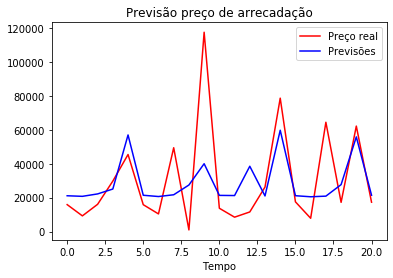

In [23]:
plt.plot(preco_real_test, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço de arrecadação')
plt.xlabel('Tempo')
plt.ylabel('')
plt.legend()
plt.show()